<font color="green">**K - Nearest Neighbor model for stock prediction using stock data and weight vector analysis - Avoid Data Snooping**</font>

**Import Libraries**

In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd

#Data Scaling Libraries
from sklearn.preprocessing import MinMaxScaler

#Error Metrics Libraries
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#KNN Libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

##SAE Libraries
from keras.layers import Input, Dense
from keras.models import Model

#Data Visualization Library
plt.style.use('fivethirtyeight')

In [2]:
#Get the stock quote 
df = web.DataReader('DIS', data_source='yahoo', start='2016-07-22', end='2020-09-26') 

In [3]:
df.head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-07-22,98.419998,97.470001,98.389999,97.709999,5381700.0,92.853477
2016-07-25,98.059998,97.250000,97.900002,97.389999,4825500.0,92.549377
2016-07-26,97.160004,96.339996,97.019997,96.690002,6274800.0,91.884163
2016-07-27,96.930000,95.860001,96.699997,96.330002,6911400.0,91.542076
2016-07-28,96.489998,95.820000,96.400002,95.910004,7713500.0,91.142944


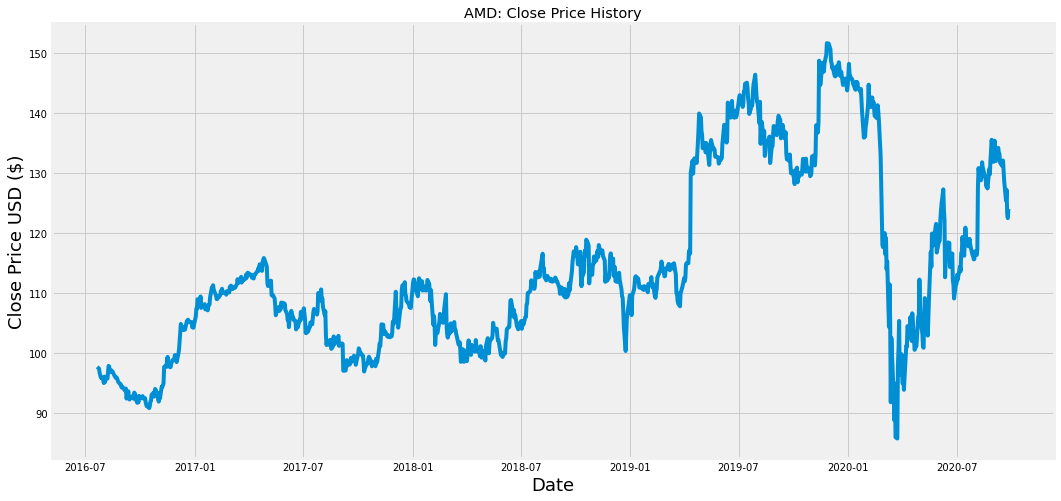

In [4]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('AMD: Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

**Preprocess data and split into train-test datasets**

In [5]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close', 'Open', 'Volume'])

#Converting the dataframe to a numpy array
dataset = data.values

#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)
print("Train Data Length: ", training_data_len)

Train Data Length:  843


In [6]:
train_data = dataset[:training_data_len,:]
test_data = dataset[training_data_len - 60: , : ]

In [7]:
#Scale the Training data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_train_data = scaler.fit_transform(train_data)

In [8]:
#Create the scaled training data set 
train_data = scaled_train_data

#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,:])
  y_train.append(dataset[i,0])

In [9]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [10]:
x_train.shape

(783, 60, 3)

**KNN: Build model and train using the training data**

In [11]:
#using gridsearch to find the best parameter
params = {'n_neighbors':[1,2,3,4,5]}
knn = neighbors.KNeighborsRegressor(n_neighbors=5)  ## Neighbors with size 1,5,20 is tested with 5 as the optimal performer
model = GridSearchCV(knn, params, cv=10)

x_train = x_train.reshape(783,180)

#fit the model on training data
model.fit(x_train,y_train)


GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [12]:
#Scale the Testing data to be values between 0 and 1 (This scaling is done after fitting the LR model)

scaled_test_data = scaler.fit_transform(test_data)

#Test data set
test_data = scaled_test_data

#Create the x_test and y_test data sets
x_test = []
y_test =  df['Close'][training_data_len :]

for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,:])

#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [13]:
x_test.shape

(210, 60, 3)

**Predict on testing data and visualize predictions**

In [14]:
nsamples_test, nx_test, ny_test = x_test.shape
x_test = x_test.reshape((nsamples_test,nx_test*ny_test))

In [15]:
preds = model.predict(x_test)
preds = preds.reshape(-1,1)
# preds = scaler.inverse_transform(preds)#Undo scaling

rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
print("RMS: ",rms)

RMS:  20.55798285346175


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


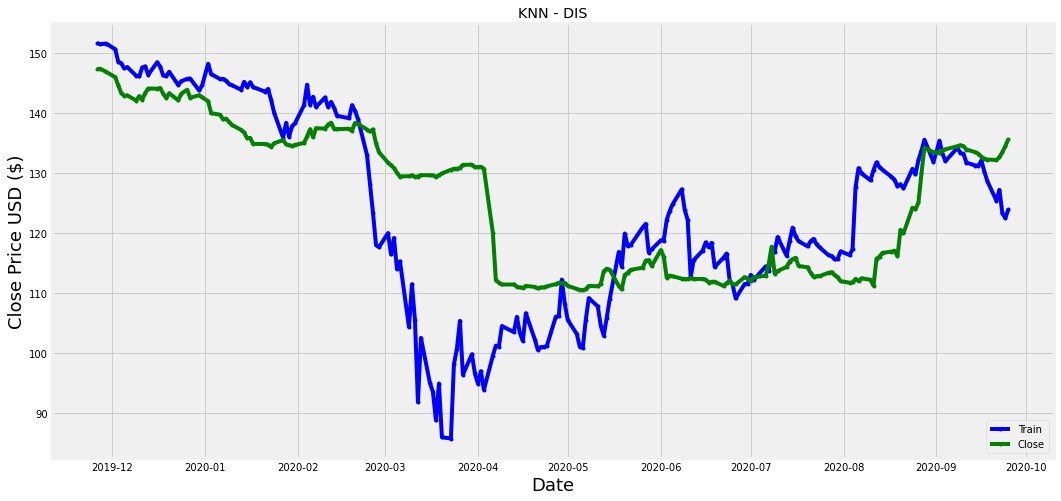

In [16]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
close = df['Close'][training_data_len:]
valid['Predictions'] = preds
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('KNN - DIS')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df['Close'][training_data_len:],marker='.',color='#0000FF')
plt.plot(valid['Predictions'],marker='.',color='#008000')
plt.legend(['Train','Close', 'Predictions'], loc='lower right')
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


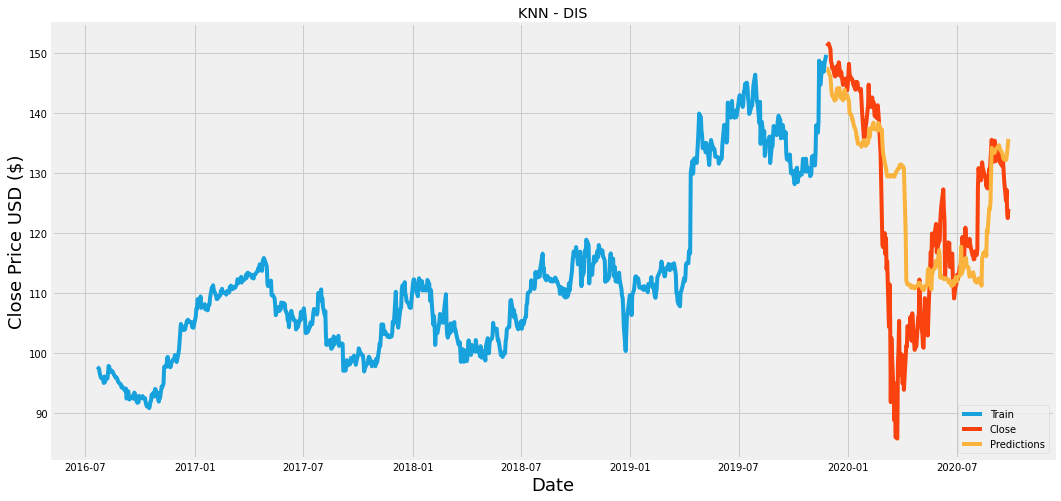

In [17]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
close = df['Close'][training_data_len:]
valid['Predictions'] = preds
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('KNN - DIS')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'], color='#17A2DE')
plt.plot(valid['Close'],color='#FA420E')
plt.plot(valid['Predictions'],color='#FAB43D')
# plt.plot(valid[['Adj Close','Predictions']])
plt.legend(['Train','Close', 'Predictions'], loc='lower right')
plt.show()